# Problem Set 2

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on bCourses). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of surveys conducted in 1998
 * "Wave 2" of surveys conducted in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from bCourses. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 1|
|progresa |treatment =1|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|schooling in 1997|
|grc97  |grade enrolled in 1997

---

## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Present summary statistics (mean, median and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

*Note:* For this and subsequent problems, you will need to be careful in how you deal with missing (NULL) values. You should not blindly drop rows and columns where any data field is missing.  For instance, in calculating the average `hohwag`, you should average the `hohwag` values from all households that report a value (even if the household does not have a recorded `age` value, for example). 

In [1]:
import pandas as pd
df = pd.read_csv('progresa_sample.csv')

In [2]:
# Convert the poor and progresa
df.loc[df.poor == 'pobre','poor'] = 1
df.loc[df.poor == 'no pobre','poor'] = 0
df.loc[df.progresa == 'basal','progresa'] = 1
df.loc[df.progresa == '0','progresa'] = 0

df['poor'] = df['poor'].astype(float, errors = 'raise')
df['progresa'] = df['progresa'].astype(float, errors = 'raise')

In [3]:
# Drop the columns
df_1 = df.drop(['year','folnum','village'],axis = 1)
summary_table = df_1.describe().loc[['mean','50%','std']].T.sort_index()
summary_table.rename(columns = {'50%':'median'},inplace = True)
summary_table

,mean,median,std
age,11.366460,11.000000,3.167744
dist_cap,147.674452,132.001494,76.063134
dist_sec,2.418910,2.279000,2.234109
fam_n,7.215715,7.000000,2.352900
grc,3.963537,4.000000,2.499063
grc97,3.705372,4.000000,2.572387
hohage,44.436717,43.000000,11.620372
hohedu,2.768104,2.000000,2.656106
hohsex,0.925185,1.000000,0.263095
hohwag,586.985312,500.000000,788.133664


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages?  Present your results in a single table with the following columns and 14 (or so) rows (alphabetized by variable name):


| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|

 *Hint:* Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 from poor households (i.e., poor=='pobre').



In [11]:
# Filter the data into treat and control set
treat = df[(df.year == 97) & (df.poor == 1) & (df.progresa == 1)]
control = df[(df.year == 97) & (df.poor == 1) & (df.progresa == 0)]
# Drop some features to choose demographic characteristic
treat = treat.drop(['year','poor','progresa','village','folnum','sc','grc'],axis=1)
control = control.drop(['year','poor','progresa','village','folnum','sc','grc'],axis=1)

In [12]:
# Check for equal variance as indicated on piazza
col_names = treat.columns.tolist()
var_list = []

from scipy.stats import levene
for i in col_names:
    stat, p = levene(treat[i].dropna(),control[i].dropna())
    var_list.append(p)
    
print(var_list)

[0.012191721753402001, 0.2453603340788238, 7.249821258807836e-18, 0.231621042320414, 2.4770515637563147e-31, 5.001170600640222e-43, 0.0020382691963589396, 0.01200637015123779, 0.00034155412761578647, 0.5711857552285441, 2.6219871374206153e-05, 0.5900802055947583, 0.42668475691245145, 0.0951780559112652]


Based on the fact, some p-values are extremely smaller than 0.05, so we do not assume that there will be equal variance in the two datasets, as a result of which, we will conduct Welch's t-test

In [29]:
import scipy.stats as stats
import scipy as sp
import numpy as np
pd.reset_option('display.float_format')

treatment_value = []
control_value = []
difference_value = []
pvalue_value = []

# For each feature, calculate the mean value in two groups, its difference and the p-value
for col in col_names:
    t_stat, pvalue = sp.stats.ttest_ind(treat[col].dropna(), control[col].dropna(), equal_var = False)
    pvalue_value.append(pvalue) 
    treatment_mean = treat[col].dropna().mean()
    control_mean = control[col].dropna().mean()
    treatment_value.append(treatment_mean)
    control_value.append(control_mean)
    difference_value.append(treatment_mean - control_mean)

# Create a table to display
result = pd.DataFrame({'Variable name': col_names,
                       'Average value (Treatment villages)' : treatment_value,
                       'Average value (Control villages': control_value,
                       'Difference (Treat - Control)': difference_value,
                       'p-value': pvalue_value})

result = result.sort_values(by = 'Variable name')
result = result.reset_index(drop = True)
result

,Variable name,Average value (Treatment villages),Average value (Control villages,Difference (Treat - Control),p-value
0,age,10.716991,10.742023,-0.025032,4.783633e-01
1,dist_cap,150.829074,153.769730,-2.940656,1.146482e-03
2,dist_sec,2.453122,2.507662,-0.054540,4.266282e-02
3,fam_n,7.281327,7.302469,-0.021142,4.289667e-01
4,grc97,3.531599,3.543050,-0.011450,6.895228e-01
5,hohage,43.648828,44.276918,-0.628090,2.259461e-06
6,hohedu,2.663139,2.590348,0.072791,1.038219e-02
7,hohsex,0.924656,0.922947,0.001709,5.721253e-01
8,hohwag,544.339544,573.163558,-28.824015,3.287285e-04
9,indig,0.325986,0.332207,-0.006222,2.459021e-01


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages at baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

A:  
Yes, there are.  
Based on the p-value we gained from above, we see that some of them are smaller than 0.05, including dist_cap, dist_sec, hohage, hohedu, hohwag, min_dist, sex, welfare, which means that there exist significant differences between the control and treatment. Some of the 14 variables have the p-value bigger than 0.05, including age, fam_n, grc97, hohsex, indig, sc97, indicating that there exist no significant differences. All in all, 8 out of 14 have statistically significant differences, we con conclude that there are statistically significant differences between treatment and control villages at baseline.  
  
B:  
If there are difference at the baseline, these differences will be against the assumption we made about the measure for the impact of treatment. It may mislead the Conclusion and causal interpretation.  
  
C:  
This implies that we may add some restrictions and control onto these variables while mesauring the impact of the treament.

### 1.4 Graphical exploration, part 1

Visualize the distribution of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households). Does there appear to be a difference? Is this difference statistically significant?

In [56]:
# Filter the treat data into treat_before and treat_after
treat_before = df[(df.poor == 1) & (df.progresa == 1) & (df.year == 97)].groupby(by='village')['sc'].mean()
treat_after = df[(df.poor == 1) & (df.progresa == 1) & (df.year == 98)].groupby(by='village')['sc'].mean()

Text(0.5, 1.0, 'Avg Enrollment Rate in poor Villages (1998)')

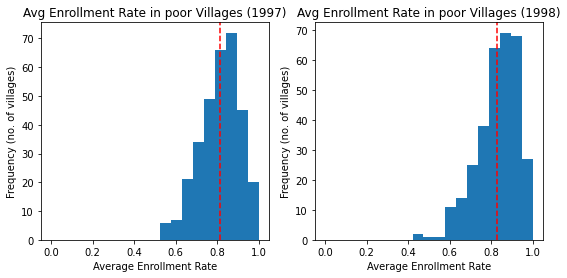

In [57]:
# Plotting
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

bins = np.linspace(0,1,20)
ax1.hist(treat_before,bins=bins)
ax1.axvline(x=treat_before.mean(), color = 'r', linestyle='--')
ax1.set_xlabel('Average Enrollment Rate')
ax1.set_ylabel('Frequency (no. of villages)')
ax1.set_title("Avg Enrollment Rate in poor Villages (1997)")

ax2.hist(treat_after,bins=bins)
ax2.axvline(x=treat_after.mean(), color = 'r', linestyle='--')
ax2.set_xlabel('Average Enrollment Rate')
ax2.set_ylabel('Frequency (no. of villages)')
ax2.set_title("Avg Enrollment Rate in poor Villages (1998)")

In [58]:
print("Average Enrollement Rate in 1997")
print(treat_before.dropna().mean())
print()
print("Average Enrollement Rate in 1998")
print(treat_after.dropna().mean())
print()
print('The result of Welch\'s t-test')
stats.ttest_ind(treat_before,treat_after,equal_var=False)

Average Enrollement Rate in 1997
0.8138394110596501

Average Enrollement Rate in 1998
0.8295362042630732

The result of Welch's t-test


Ttest_indResult(statistic=-2.015713486515638, pvalue=0.044249343422588405)

Based on the p-value of t-test, pvalue=0.044249343422588405 is smaller than 0.05, indicating that there exists statistically significant differences between these two means

### 1.5 Graphical exploration, part 2

Repeat the above exercise for poor households in **control villages**, before and after treatment. Do you observe a difference in enrollment in control villages between 1997 and 1998? How does what you observe here affect how you might approach measuring the impact of PROGRESA?

In [59]:
# Filter the treat data into treat_before and treat_after
control_before = df[(df.poor == 1) & (df.progresa == 0) & (df.year == 97)].groupby(by='village')['sc'].mean()
control_after = df[(df.poor == 1) & (df.progresa == 0) & (df.year == 98)].groupby(by='village')['sc'].mean()

Text(0.5, 1.0, 'Avg Enrollment Rate in poor Villages (1998)')

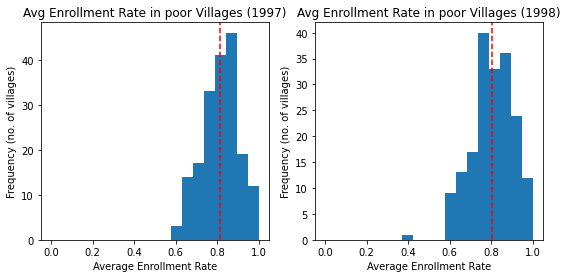

In [60]:
# Plotting
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

bins = np.linspace(0,1,20)
ax1.hist(control_before,bins=bins)
ax1.axvline(x=control_before.mean(), color = 'r', linestyle='--')
ax1.set_xlabel('Average Enrollment Rate')
ax1.set_ylabel('Frequency (no. of villages)')
ax1.set_title("Avg Enrollment Rate in poor Villages (1997)")

ax2.hist(control_after,bins=bins)
ax2.axvline(x=control_after.mean(), color = 'r', linestyle='--')
ax2.set_xlabel('Average Enrollment Rate')
ax2.set_ylabel('Frequency (no. of villages)')
ax2.set_title("Avg Enrollment Rate in poor Villages (1998)")

In [61]:
print("Average Enrollement Rate in 1997")
print(control_before.dropna().mean())
print()
print("Average Enrollement Rate in 1998")
print(control_after.dropna().mean())
print()
print('The result of Welch\'s t-test')
stats.ttest_ind(control_before,control_after,equal_var=False)

Average Enrollement Rate in 1997
0.8137762497441696

Average Enrollement Rate in 1998
0.8061845192878944

The result of Welch's t-test


Ttest_indResult(statistic=0.7816669784862521, pvalue=0.434922783132185)

Based on the result of t-test, the pvalue=0.434922783132185 is bigger than 0.05, indicating we may say that there does not exist statistically significant difference in enrollment in control villages between 1997 and 1998.  
If there is no difference in the control group, we may not necessarily conduct difference in difference approach to the enrollment rate, because the only difference made here happened in the treatment group

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on the social and economic outcomes of individuals in Mexico. We will focus on the impact of the program on school enrollment rates among the poor (those with poor=='pobre'), since only the poor were eligible to receive PROGRESA assistance, and since a primary objective of the program was to increase school enrollment.

### 2.1 Simple differences: T-test

Begin by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment), calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages. Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [62]:
treat_98 = df[(df.year == 98) & (df.poor == 1) & (df.progresa == 1)]['sc'].dropna()
control_98 = df[(df.year == 98) & (df.poor == 1) & (df.progresa == 0)]['sc'].dropna()

In [64]:
print("Average Enrollement Rate in treatment group")
print(treat_98.mean())
print()
print("Average Enrollement Rate in control group")
print(control_98.mean())
print()
print('The result of Welch\'s t-test')
stats.ttest_ind(control_98,treat_98,equal_var=False)

Average Enrollement Rate in treatment group
0.8464791213954308

Average Enrollement Rate in control group
0.807636956730308

The result of Welch's t-test


Ttest_indResult(statistic=-8.181477157107308, pvalue=2.9655072988948406e-16)

The p-value in the test is smaller than 0.05, indicating that there exists statistically significant difference between the treatment and control group in 1998. We may conclude that the poor people who received the benefit of progresa showed a higher average enrollment rate compared to that of the control group

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. For now, do not include any other variables in your regression. Discuss the following:

* Based on this model, how much did Progresa increase or decrease the likelihood of a child enrolling? Make sure you express you answer in a sentence that your grandmother could understand, using appropriate units.
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

In [65]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

data_simpleregression = df[(df.year == 98) & (df.poor == 1)]

model = smf.ols('sc ~ progresa',
                data = data_simpleregression).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           6.64e-17
Time:                        16:41:36   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8076      0.004    220.676      0.0

1. Based on this model, the averaged increase in the likelihood of a child enrolling is 3.88%. In one sentence is that with every 10000 more children received the benefit of progresa, there will be averaged 388 more children got enrolled to school in 1998.  
  
2. It is in line with the conclusion we draw from the t-test estimate. The averaged increase rate in regression analysis is 0.0388 and the difference between treat and control is about 0.039. In addition, they both say there will be significantly increase in the enrollment rate.  
  
3. The p-value we got from the regression summary is 0.000, which is less than 0.05. At 5% significance level, we can reject the null hypothesis that the treatment effects are zero.  
  
4. Counterfactual assumption: In the absense of progresa, there will be no difference in the enrollment rate among the control and treatment groups.


### 2.3 Multiple Regression

Re-run the above regression, but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, welfare index, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?
* Interpet the coefficient associated with the `dist_sec` variable. Is this evidence that the household's distance from a secondary school has a *causal* impact on educational attainment?

In [70]:
data_multipleregression = df[(df.year == 98) & (df.poor == 1)]
model2 = smf.ols(formula = 'sc~ progresa + age + dist_sec + sex + hohedu + welfare_index + indig',
                 data = data_multipleregression).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     1419.
Date:                Sat, 05 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:30:54   Log-Likelihood:                -7639.4
No. Observations:               27267   AIC:                         1.529e+04
Df Residuals:                   27259   BIC:                         1.536e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5025      0.014    105.342

1. With adding more variables, there is a slight decrease in the point estimate of treatment effect, from 0.0388 to 0.0352. 
  
2. With adding more variables, there is also a slight decrease in the standard error of the treatment effect, from 0.005 to 0.004. 
  
3. There may be some slight differences in the coefficients with adding more variables into the model. It's important to keep other variables constant and adding more variables to the model will definitely increase the R-square value. However, the point effect of treatment effect is of similiarities in the estimate of 2.2 and 2.3, which both indicate there will be a positive effect of progresa. Also, the standard error represents the average distance that the observed values fall from the regression line. Conveniently, it tells you how wrong the regression model is on average using the units of the response variable. With a decrease in the standard error, the model in 2.3 seems to be more accurate.  
  
4. With all other variables holding constant, one unit increase in the dist_sec will lead an averaged decrease of 0.0117 in the enrollment rate, which has a p-value of 0.000, indicating that this variable of statistically significance. Yes, this seems to be evidence of the household's distance from a secondary school has a causal impact on educational attainment

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in control villages. 

Display your results in a 2x2 table where the rows are Control/Treatment and the columns are 1997/1998. 

* What is your difference-in-difference estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [72]:
control_97 = df[(df.year == 97) & (df.poor == 1) & (df.progresa == 0)]['sc'].mean()
control_98 = df[(df.year == 98) & (df.poor == 1) & (df.progresa == 0)]['sc'].mean()
treat_97 = df[(df.year == 97) & (df.poor == 1) & (df.progresa == 1)]['sc'].mean()
treat_98 = df[(df.year == 98) & (df.poor == 1) & (df.progresa == 1)]['sc'].mean()

In [73]:
result = pd.DataFrame(data=[[control_97,control_98],
                            [treat_97,treat_98]],
                      columns = [1997,1998],
                      index = ['control','treat'])
result

,1997,1998
control,0.815186,0.807637
treat,0.822697,0.846479


In [74]:
did = treat_98 - control_98 - (treat_97 - control_97)
did

0.031331280319323085

1. The estimate of the impact using difference-in-difference approach is 0.031, which is slightly smaller than the estimate of 2.2 and 2.3. 
2. The counterfactual assumption is that in the absence of progresa treatment, the differences between 1997 and 1998 in the control and treatment group would be the same.  

### 2.5 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment effects of the program in a difference-in-differences, for the poor households. Do this (i) first without including any control variables; and then (ii) do it a second time including at least 5 control variables. 

* What is your estimate (i) of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* Does your estimate of the impact of Progresa from (i) change when you add control variables as in (ii)? How do you explain these changes, or the lack of changes on the `progresa` coefficient between (i) and (ii)?
* How do the estimates from (i) and (ii) compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences, if any exist?
* What is the counterfactual assumption underlying regression (ii)? 

In [82]:
df_poor = df[df.poor == 1]

In [84]:
df_poor.loc[df_poor['year'] == 97, 'year'] = 0
df_poor.loc[df_poor['year'] == 98, 'year'] = 1

/Users/zhouyi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [88]:
model3 = smf.ols('sc ~ progresa',
                 data = df_poor).fit()
model4 = smf.ols('sc ~ progresa*year + sex + dist_sec + age + welfare_index + hohedu + progresa + year',
                 data = df_poor).fit()

In [89]:
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     47.30
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           6.16e-12
Time:                        20:36:17   Log-Likelihood:                -26261.
No. Observations:               58372   AIC:                         5.253e+04
Df Residuals:                   58370   BIC:                         5.254e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8116      0.003    318.680      0.0

In [90]:
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     2754.
Date:                Sat, 05 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:36:18   Log-Likelihood:                -16832.
No. Observations:               58200   AIC:                         3.368e+04
Df Residuals:                   58191   BIC:                         3.376e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4915      0.010    152.780

1. From the model3 summary, we see that the coefficient of progresa is 0.0222 with standard error of 0.003 and p-value of 0.000. The interpretation of this coefficent is that the averaged enrollment rate of household who received progresa(treat) is 0.0222 higher than that of people who didn't receive progresa(control)

2. Yes, it will change. This time with more variables adding to this model, we will dive a little deeper into this.  
* The progresa coefficient alone, has the coefficient of 0.0038, with standard error of 0.004 and p-value of 0.318 which is bigger than 0.05, making it no longer statistically significant for the regression model. The impact of this variable is no longer significant for this model.  
* The year. We include this variable to conduct difference in difference analysis. The coefficient is 0.0279, with standard error of 0.004 and p-value of 0.000, making it statistically significant for the regression model. This term indicates that for the year 1998, the averaged enrollment rate is increased 0.0279 in comparison to 1997.  
* The progresa\*year term. This is the relevant interaction between progresa and year variables that we can estimate the impact of the progresa program. It has the coefficient 0.0309, with standard error 0.006 and p-value of 0.000, making it statistically significant for the regression model. The interpretation of this variable is that the averaged enrollment rate of the progresa family would be 0.0309 higher than other groups in the year 1998.  
Thus based on the analysis, we can see that the progresa variable is not statistically significant for the model with adding more variables and there exist positive increamental effect from the year and progresa\*year. The impact of progresa is represented by progresa\*year, which is 0.0309. 
3. The difference-in-difference estimates from 2.4 is 0.0313, the estimates from (i) is 0.0222 and from (ii) is 0.0309. From my perspective, the estimate from (i) is not that reasonable compared to the other two estimates, since it did not consider other variables. With adding more variables to the regression model, the estimate is just slightly smaller than that from the DiD approach. I think the difference is originated by introducing other extra varibles into our model.  
4. Counterfactual assumption: In the absence of treatment, the change of treatment group and control group over the time 1997 to 1998 is the same, also known as the parallel trend assumption


### 2.6 Spillover effects

Thus far, we have focused on the impact of PROGRESA on the school enrollment of poor households. Repeat your analysis in 2.5, instead focusing on (a) the impact of PROGRESA on the school enrollment of non-poor households, and (b) the impact ofo PROGRESA on *other outcomes* of poor households that might plausibly have been affected by the PROGRESA program.
* Do you observe any impacts of PROGRESA on the school enrollment of the non-poor?
* Regardless of whether you find evidence of spillovers to non-poor, describe one or two reasons why PROGRESA *might* have impacted non-poor households. Give concrete examples based on the context in which PROGRESA was implemented.
* Do you observe any impacts of PROGRESA on other aspects of the welfare of poor households? 

In [92]:
df_nonpoor = df[df.poor == 0]

In [93]:
df_nonpoor.loc[df_nonpoor['year'] == 97, 'year'] = 0
df_nonpoor.loc[df_nonpoor['year'] == 98, 'year'] = 1

/Users/zhouyi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [98]:
model5 = smf.ols('sc ~ progresa*year + sex + dist_sec + age + welfare_index + hohedu + progresa + year',
                 data = df_nonpoor).fit()
model6 = smf.ols('fam_n ~ progresa*year + progresa + year',
                 data = df_poor).fit()

In [99]:
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     510.5
Date:                Sat, 05 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:32:25   Log-Likelihood:                -3700.0
No. Observations:               10379   AIC:                             7418.
Df Residuals:                   10370   BIC:                             7483.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4479      0.030     49.046

In [100]:
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:                  fam_n   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4205
Date:                Sat, 05 Feb 2022   Prob (F-statistic):              0.738
Time:                        22:32:32   Log-Likelihood:            -1.4833e+05
No. Observations:               65392   AIC:                         2.967e+05
Df Residuals:                   65388   BIC:                         2.967e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.3025      0.021    348.798

1. Based on the model summary above, we can see that the progresa and year term both have a rather small p-value(smaller than 0.05), making them statistically significant. The progresa term indicates that the non-poor household recerving the progresa subsidy has an averaged 0.0286 higher enrollment rate compared to those who do not. And the year term indicates that in 1998, there existed a 0.0380 higher enrollment rate compared to 1997.  
 However, when we look at the term progresa:year, the p-value of which is 0.909, making it not statistically significant for our regression model. Therefore, the difference-in-differences impact is not statistically significant in this case.  
  
2. The reason: Based on the goal of this program, the non-poor households should not receive the progresa subsidy. However, in the reality this situation(non-poor people also receive the benefit of progresa) could have happened due to some out-of-control reasons like corruption.  
 And probaby due to the snowball effect, the non-poor household noticed that the children from poor households started to get enrolled in the school and they choose to send them to schools too.  
  
3. In this case, I would like to figure out whether progresa program has lead an impact on the family size among the poor villages. In this regression summary, the p-values of the progresa, year and progresa\*year terms are all bigger than 0.05, making them not statistically significant. I may say that based on the statistical significance of the treatment effect, the progresa may not lead an impact on the family size. The reason may be the time span is too short, and in the long run, it probably may have some impact.

### 2.7 Summary

* Based on all the analysis you have undertaken to date, do you believe that Progresa had a causal impact on the enrollment rates of poor households in Mexico? 
* Using several different empirical frameworks, we have explored the impact of the PROGRESA program on enrollment rates of poor households in Mexico. In general, it appears that PROGRESA did have positive impact on the school enrollment rates, though the exact estimate depends on the method used to measure impact. After controlling for other observable characteristics, the most reliable difference-in-difference estimator estimates that PROGRESA raised enrollment rates by roughly 3.13 percentage points. A separate estimator, that includes externalities on non-poor households, produces a more conservative, and statistically insignificant, estimate.

*Discuss your results here*